In [3]:
# import libraries
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tomotopy as tp
import re

# for NLP
import spacy 
import tomotopy as tp
import gensim
from gensim.models import Phrases


In [39]:
# import data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,helpfulness_cat,imdb_user_review
0,1.0,It is hard to find such delightful and adorabl...
1,1.0,"They don't make films like this faded, hauntin..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...
3,1.0,I doubt that I'd ever seen anything resembling...
4,1.0,I was shocked to find myself riveted to this m...


In [4]:
print(sum(train['helpfulness_cat'])/len(train))


0.7637377963737796


In [5]:
document_lengths = np.array(list(map(len, train['imdb_user_review'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 175.48888888888888.
The minimum number of words in a document is: 6.
The maximum number of words in a document is: 3954.


/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of number of words'}, xlabel='Number of words', ylabel='Density'>

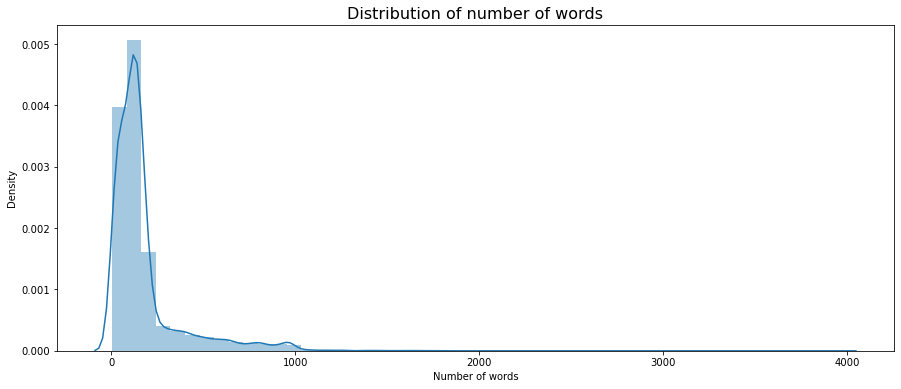

In [6]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax)

In [7]:
print("There are {} documents with over 1500 words.".format(sum(document_lengths > 1500)))
print("There are {} documents with max 6 words.".format(sum(document_lengths <= 6)))

There are 9 documents with over 1500 words.
There are 2 documents with max 6 words.


### Basic Data Cleansing

In [40]:
# data sample
train['imdb_user_review'].to_list()

['It is hard to find such delightful and adorable movies these days as \\"The Kid\\". It is a silent movie but so rich, winning and beautiful that you don\\u00b4t nead words. Chaplin and 6-year old Coogan are possibly the most charming pair I have ever seen in my life. The film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental. I always get my eyes full with tears of saddness and happiness. And I really never cry in movies. And the music...its simply Oscar-level! The movie is sympathetic, full of feeling, touchingly funny moments. It is truly a masterpiece showing how extraordinary talented person Charlie Chaplin was considering this film is respectively over 80 years old! So don\\u00b4t you miss it because of it\\u00b4s age, don\\u00b4t miss it.',
 'They don\'t make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of the m

In [41]:
import re
def basic_clean(text):
    """
    Remove \\,\n,\t,... from text
    Remove whitespace from text
    change to lowercase
    """
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\'', '').replace('"',' ')
    pattern = re.compile(r'\s+')
    Formatted_text = Formatted_text.lower()
    Formatted_text = Formatted_text.replace(r'u00b4','') 
    Formatted_text = Formatted_text.replace(r'u0085', '')
    Formatted_text = Formatted_text.replace('\\',' ')
    Without_whitespace = re.sub(pattern, ' ', Formatted_text)
    Formatted_text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    without_digit = re.sub(r'[^A-Za-z0-9]+'," ", Formatted_text)
    final_text = ''.join([i for i in without_digit if not i.isdigit()])
    return final_text

In [42]:
# cleaning data
train['imdb_user_review'] = train['imdb_user_review'].apply(basic_clean)

In [43]:
train['imdb_user_review'].to_list()

['it is hard to find such delightful and adorable movies these days as the kid it is a silent movie but so rich winning and beautiful that you don t nead words chaplin and 6 year old coogan are possibly the most charming pair i have ever seen in my life the film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental i always get my eyes full with tears of saddness and happiness and i really never cry in movies and the music its simply oscar level the movie is sympathetic full of feeling touchingly funny moments it is truly a masterpiece showing how extraordinary talented person charlie chaplin was considering this film is respectively over 80 years old so don t you miss it because of it s age don t miss it ',
 'they dont make films like this faded haunting masterpiece of silent cinema anymore when dracula was first put on sale for movie rights the one of the first men to grab it was f w murnau one of the most of the famous german directors of his time by

In [29]:
train.head(10)

,helpfulness_cat,imdb_user_review
0,1.0,it is hard to find such delightful and adorabl...
1,1.0,"they don t make films like this faded, hauntin..."
2,1.0,i first viewed this movie in 1924 at age 6 yrs...
3,1.0,i doubt that i d ever seen anything resembling...
4,1.0,i was shocked to find myself riveted to this m...
5,0.0,the movie is best described as pathetic. it ma...
6,0.0,well i was watching this movie for whatever re...
7,1.0,buster keaton once said that if he hadn t been...
8,1.0,let me join the consensus and call charlie cha...
9,1.0,"once again chaplin plays his famous creation, ..."


Sentiment Analysis

In [46]:
# install transformers
#!pip install -q transformers

In [149]:
# # using fine tuned bertmodel based on tweet dataset to analyse sentiment
# from transformers import pipeline
 
# # Set up the inference pipeline using a model from the 🤗 Hub
# sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [150]:
# # update sentiment analysis model config
# sentiment_analysis.model.config.update({"max_position_embeddings":1000,"max_seq_length":512})

In [ ]:
# from transformers import pipeline
 
# # Set up the inference pipeline using a model from the 🤗 Hub
# sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
 
# # Let's run the sentiment analysis on each tweet
# sentiment = []
# for review in train['imdb_user_review']:
#    try:
#      content = [review]
#      sentiment = sentiment_analysis(content)
#      review.append({'tweet': content, 'sentiment': sentiment[0]['label']})
 
#    except:
#      pass

In [ ]:
'''
index error: 
Token indices sequence length is longer than the specified maximum sequence length for this model (176 > 128)
Due to the length of reviews, the model cannot handle them.
'''

In [6]:
# using roberta-large-mnli model to analyse sentiment
from transformers import pipeline
pipe = pipeline(model="roberta-large-mnli",return_all_scores=True)

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
CONTRADICTION = []
NEUTRAL = []
ENTAILMENT = []

for review in train['imdb_user_review']:
   try:
    temp = 0
    temp = pipe(review)[0][0]['score']
    CONTRADICTION.append(temp)

    temp = pipe(review)[0][1]['score']
    NEUTRAL.append(temp)

    temp = pipe(review)[0][2]['score']
    ENTAILMENT.append(temp)
   except:
     temp = 0
     CONTRADICTION.append(temp)
     NEUTRAL.append(temp)
     ENTAILMENT.append(temp)

In [11]:
# combine contradiction, neutral and entailment into a data frame
train_sentiment = pd.DataFrame({'CONTRADICTION': CONTRADICTION, 'NEUTRAL': NEUTRAL, 'ENTAILMENT': ENTAILMENT})
train_sentiment.to_csv('train_sentiment.csv', index=False)

In [19]:
# load the sentiment dataframe
train_sentiment = pd.read_csv('train_sentiment.csv')

In [20]:
# combine healpfulness and sentiment into a data frame
train_sentiment['helpfulness_cat'] = train['helpfulness_cat']

In [21]:
train_sentiment.head()

,CONTRADICTION,NEUTRAL,ENTAILMENT,helpfulness_cat
0,0.301088,0.670759,0.028153,1.0
1,0.031557,0.959142,0.009301,1.0
2,0.000880,0.994948,0.004172,1.0
3,0.441404,0.545666,0.012929,1.0
4,0.083177,0.886534,0.030290,1.0


In [18]:
# get the avg score for reviews
print("The average contradiction score for unhelpful reviews is: {}.".format(np.mean(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 0])))
print("The average contradiction score for helpful reviews is: {}.".format(np.mean(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 1])))
print("The average neutral score for unhelpful reviews is: {}.".format(np.mean(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 0])))
print("The average neutral score for helpful reviews is: {}.".format(np.mean(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 1])))
print("The average entailment score for unhelpful reviews is: {}.".format(np.mean(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 0])))
print("The average entailment score for helpful reviews is: {}.".format(np.mean(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 1])))


The average contradiction score for unhelpful reviews is: 0.12952283451497476.
The average contradiction score for helpful reviews is: 0.10519036463656863.
The average neutral score for unhelpful reviews is: 0.7467805991370402.
The average neutral score for helpful reviews is: 0.7229228923420817.
The average entailment score for unhelpful reviews is: 0.07568397245021018.
The average entailment score for helpful reviews is: 0.054647882621228404.


/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0, 'Sentiment score')

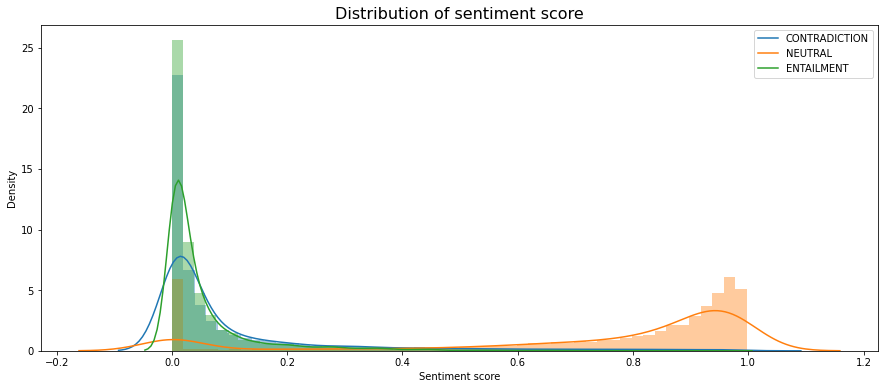

In [14]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 1], bins=50, ax=ax)
# plot legend
ax.legend(['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT'])
ax.set_xlabel("Sentiment score")


/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0, 'Sentiment score')

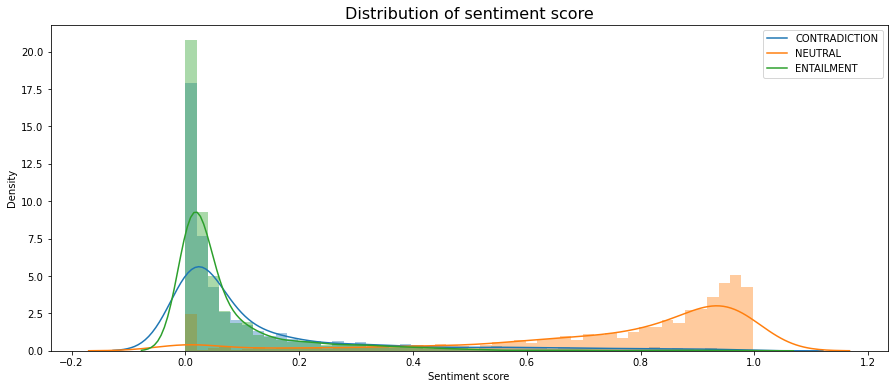

In [15]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 0], bins=50, ax=ax)
# plot legend
ax.legend(['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT'])
ax.set_xlabel("Sentiment score")

In [120]:
# using nltk vader to carry out sentiment analysis
import nltk
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ash/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
# create a function to calculate the sentiment score
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_score(text):
    score = sent_analyzer.polarity_scores(text)
    score.pop('compound')
    return score

In [21]:
# calculate the sentiment score for each review and create neg, neu and pos columns
train['neg'] = train['imdb_user_review'].apply(sentiment_score).apply(lambda x: x['neg'])
train['neu'] = train['imdb_user_review'].apply(sentiment_score).apply(lambda x: x['neu'])
train['pos'] = train['imdb_user_review'].apply(sentiment_score).apply(lambda x: x['pos'])
train.head()


,helpfulness_cat,imdb_user_review,neg,neu,pos
0,1.0,it is hard to find such delightful and adorabl...,0.072,0.540,0.387
1,1.0,"they don t make films like this faded, hauntin...",0.081,0.854,0.065
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.045,0.749,0.206
3,1.0,i doubt that i d ever seen anything resembling...,0.116,0.748,0.135
4,1.0,i was shocked to find myself riveted to this m...,0.058,0.797,0.145


In [22]:
# export the sentiment score to csv
train.to_csv('train_pos_neg_sentiment_score.csv', index=False)

In [23]:
# get the avg score for reviews
print("The average negative score for unhelpful reviews is: {}.".format(np.mean(train['neg'][train['helpfulness_cat'] == 0])))
print("The average negative score for helpful reviews is: {}.".format(np.mean(train['neg'][train['helpfulness_cat'] == 1])))
print("The average neutral score for unhelpful reviews is: {}.".format(np.mean(train['neu'][train['helpfulness_cat'] == 0])))
print("The average neutral score for helpful reviews is: {}.".format(np.mean(train['neu'][train['helpfulness_cat'] == 1])))
print("The average positive score for unhelpful reviews is: {}.".format(np.mean(train['pos'][train['helpfulness_cat'] == 0])))
print("The average positive score for helpful reviews is: {}.".format(np.mean(train['pos'][train['helpfulness_cat'] == 1])))


The average negative score for unhelpful reviews is: 0.11789925226288862.
The average negative score for helpful reviews is: 0.09155953250547828.
The average neutral score for unhelpful reviews is: 0.7268256591892942.
The average neutral score for helpful reviews is: 0.7353839785731674.
The average positive score for unhelpful reviews is: 0.15527902400629673.
The average positive score for helpful reviews is: 0.17305028000973946.


/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0, 'Sentiment score')

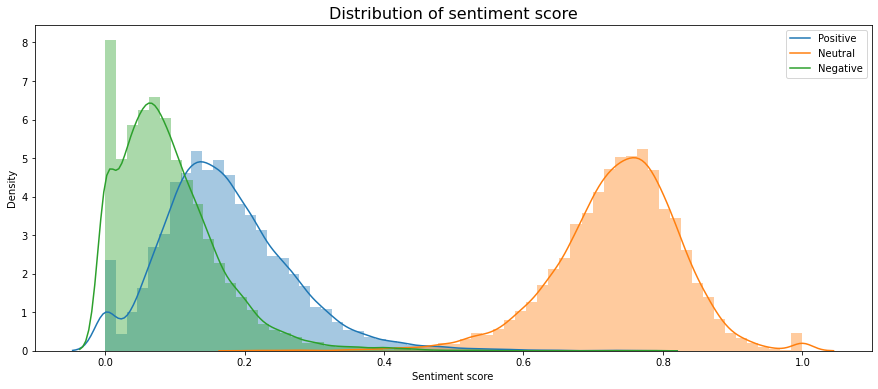

In [146]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train['pos'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train['neu'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train['neg'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
# plot legend
ax.legend(['Positive', 'Neutral', 'Negative'])
ax.set_xlabel("Sentiment score")


/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

Text(0.5, 0, 'Sentiment score')

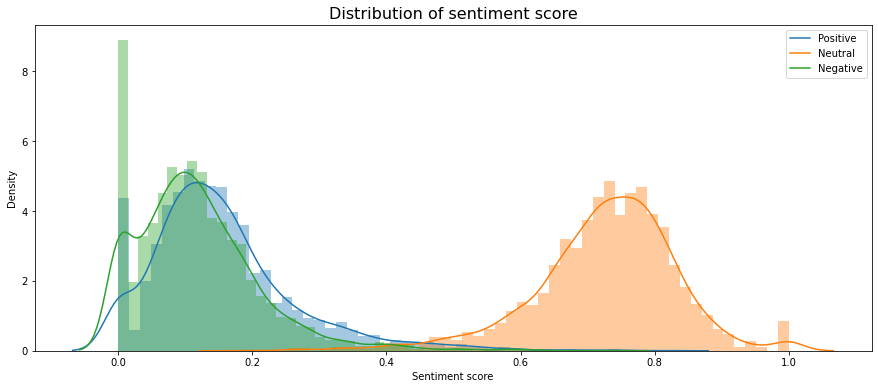

In [147]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train['pos'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train['neu'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train['neg'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
# plot legend
ax.legend(['Positive', 'Neutral', 'Negative'])
ax.set_xlabel("Sentiment score")

In [156]:
# get subjectivity score for each review
from textblob import TextBlob
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

train['subjective_score'] = train['imdb_user_review'].apply(getSubjectivity)
train.head()

,helpfulness_cat,imdb_user_review,subjective_score
0,1.0,it is hard to find such delightful and adorabl...,0.637457
1,1.0,"they don t make films like this faded, hauntin...",0.376882
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.601871
3,1.0,i doubt that i d ever seen anything resembling...,0.588847
4,1.0,i was shocked to find myself riveted to this m...,0.409792


/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ash/miniconda3/envs/nlp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Subjectivity score')

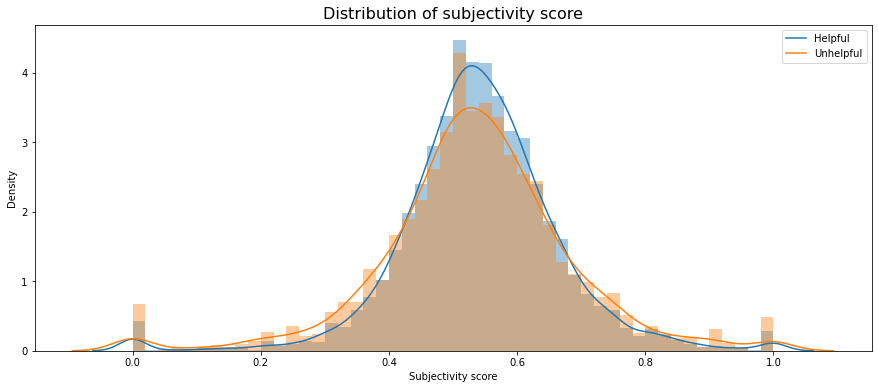

In [157]:
# plot the distribution for subjectivity score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of subjectivity score", fontsize=16)
sns.distplot(train['subjective_score'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train['subjective_score'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
# plot legend
ax.legend(['Helpful', 'Unhelpful'])
ax.set_xlabel("Subjectivity score")

In [158]:
# get the avg score for reviews
print("The average subjectivity score for unhelpful reviews is: {}.".format(np.mean(train['subjective_score'][train['helpfulness_cat'] == 0])))
print("The average subjectivity score for helpful reviews is: {}.".format(np.mean(train['subjective_score'][train['helpfulness_cat'] == 1])))


The average subjectivity score for unhelpful reviews is: 0.5352883013500236.
The average subjectivity score for helpful reviews is: 0.5410528095834198.


LDA

In [24]:
# create a small sample of the training data
train = train[:100]
train

,helpfulness_cat,imdb_user_review,neg,neu,pos
0,1.0,it is hard to find such delightful and adorabl...,0.072,0.540,0.387
1,1.0,"they don t make films like this faded, hauntin...",0.081,0.854,0.065
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.045,0.749,0.206
3,1.0,i doubt that i d ever seen anything resembling...,0.116,0.748,0.135
4,1.0,i was shocked to find myself riveted to this m...,0.058,0.797,0.145
...,...,...,...,...,...
95,1.0,i don t know why this movie always hooks me th...,0.135,0.652,0.214
96,1.0,what a genius joseph l manckiewicz was. a lite...,0.037,0.866,0.097
97,1.0,when i first saw this movie i didn t think i w...,0.035,0.767,0.198
98,1.0,bogart stretches his acting muscles and allows...,0.079,0.750,0.171


In [25]:
# LDA
nlp = spacy.load("en_core_web_sm")
docs_tokens, tmp_tokens = [], []
for item in train.loc[:, "imdb_user_review"].to_list():
    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    docs_tokens.append(tmp_tokens)
    tmp_tokens = []

# Doc2Vec

In [78]:
# create a new balanced dataset
unhelpful = train.loc[train["helpfulness_cat"] == 0, ["imdb_user_review", "helpfulness_cat"]]
helpful = train.loc[train["helpfulness_cat"] == 1, ["imdb_user_review", "helpfulness_cat"]]
helpful = helpful.sample(n=len(unhelpful), random_state=42)
s = pd.concat([unhelpful, helpful]) # create a more balanced training set for training the model

In [46]:
#import Doc2vec libraries
from nltk.tokenize import wordpunct_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [80]:
# split the trainaing data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(s['imdb_user_review'], 
                                                    s.helpfulness_cat, 
                                                    random_state=123,
                                                    test_size=0.3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3557,)
(3557,)
(1525,)
(1525,)


In [49]:
#tokenize the quotes for training dataset
tkn_quotes_train = [wordpunct_tokenize(quote.lower()) for quote in x_train.to_list()] 
tgd_quotes_train = [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes_train)]

In [50]:
#tokenize the quotes for testing dataset
tkn_quotes_test= [wordpunct_tokenize(quote.lower()) for quote in x_test.to_list()] 
tgd_quotes_test = [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes_test)]

In [81]:
#tokenize the quotes for training dataset
tkn_quotes = [wordpunct_tokenize(quote.lower()) for quote in s['imdb_user_review'].to_list()] 
tgd_quotes= [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes)]

In [82]:
# build doc2vec model with DBOW approach - using the whole dataset to train the model
model_d2v = Doc2Vec(
    tgd_quotes, vector_size=300, 
    window=2, min_count=1, workers=4, 
    epochs=100,negative=5
    )

In [ ]:
# accessing the doc2vec model

In [106]:
#vectorise the training and testing dataset separately
quote_vectors_train  = [model_d2v.infer_vector(tgd_quotes_train[i].words) 
                        for i in range(len(tgd_quotes_train))]

quote_vectors_test  = [model_d2v.infer_vector(tgd_quotes_test[i].words) 
                        for i in range(len(tgd_quotes_test))]

In [107]:
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(quote_vectors_train, y_train)

LogisticRegression()

In [108]:
#evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(logreg.score(quote_vectors_test, y_test))
y_pred = logreg.predict(quote_vectors_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.639344262295082
Testing accuracy 0.639344262295082
              precision    recall  f1-score   support

         0.0       0.62      0.70      0.66       752
         1.0       0.66      0.58      0.62       773

    accuracy                           0.64      1525
   macro avg       0.64      0.64      0.64      1525
weighted avg       0.64      0.64      0.64      1525



In [109]:
# naive bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

#scale the train data to get rid of negative values before fitting the naive bayes model
scaler = MinMaxScaler()
scaled_vectors_train = scaler.fit_transform(quote_vectors_train)

# fit naive bayes model
mnb = MultinomialNB()
mnb.fit(scaled_vectors_train, y_train)

MultinomialNB()

In [110]:
#scale the test data
scaled_vectors_test = scaler.fit_transform(quote_vectors_test)

# naive bayes model evaluation - accuracy and F1 score
print(mnb.score(scaled_vectors_test, y_test))
y_pred = mnb.predict(scaled_vectors_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6642622950819672
Testing accuracy 0.6642622950819672
              precision    recall  f1-score   support

         0.0       0.63      0.77      0.69       752
         1.0       0.71      0.57      0.63       773

    accuracy                           0.66      1525
   macro avg       0.67      0.67      0.66      1525
weighted avg       0.67      0.66      0.66      1525



In [92]:
# Doc2Vec with distributed memory approach - use the whole dataset to fit the model
model_dm = Doc2Vec(
    tgd_quotes, dm = 1, dm_mean = 1,
    vector_size=300, window=2, min_count=1, 
    workers=4, epochs=100,negative=5
    )

In [111]:
#vectorise the train and test dataset
dm_vectors_train  = [model_dm.infer_vector(tgd_quotes_train[i].words) 
                        for i in range(len(tgd_quotes_train))]

dm_vectors_test  = [model_dm.infer_vector(tgd_quotes_test[i].words) 
                        for i in range(len(tgd_quotes_test))]


In [112]:
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(dm_vectors_train, y_train)

LogisticRegression()

In [ ]:
# model evaluation
print(logreg.score(dm_vectors_test, y_test))
y_pred = logreg.predict(dm_vectors_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [96]:
#naive bayes model

#scale the data to get rid of negative values
scaler = MinMaxScaler()
scaled_dm_train = scaler.fit_transform(dm_vectors_train)

# fit naive bayes model
mnb = MultinomialNB()
mnb.fit(scaled_dm_train, y_train)

MultinomialNB()

In [97]:
#scale the test data
scaled_dm_test = scaler.fit_transform(dm_vectors_test)

# naive bayes model evaluation - accuracy and F1 score
print(mnb.score(scaled_dm_test, y_test))
y_pred = mnb.predict(scaled_dm_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6727868852459017
Testing accuracy 0.6727868852459017
              precision    recall  f1-score   support

         0.0       0.63      0.80      0.71       752
         1.0       0.74      0.54      0.63       773

    accuracy                           0.67      1525
   macro avg       0.69      0.67      0.67      1525
weighted avg       0.69      0.67      0.67      1525



DM: This is the Doc2Vec model analogous to CBOW model in Word2vec. The paragraph vectors are obtained by training a neural network on the task of inferring a center word based on context words and a context paragraph.

DBOW: This is the Doc2Vec model analogus to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

In [98]:
#delete the ram
model_d2v.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [99]:
#model pairing - combine the doc2vec models with DM and DBOW approach
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_d2v, model_dm])


In [100]:
#vectorise the training and testing data with the combined model
new_vectors_train  = [model_new.infer_vector(tgd_quotes_train[i][0]) 
                        for i in range(len(tgd_quotes_train), epochs = 20)]

new_vectors_test  = [model_new.infer_vector(tgd_quotes_test[i][0]) 
                        for i in range(len(tgd_quotes_test), epochs = 20)]

In [101]:
#fit the logistic regression model
lr_new = LogisticRegression(solver='liblinear')
lr_new.fit(new_vectors_train, y_train)

LogisticRegression(solver='liblinear')

In [102]:
# model evaluation on the test data

from sklearn.metrics import classification_report
print(lr_new.score(new_vectors_test, y_test))
y_pred_new = lr_new.predict(new_vectors_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

0.6367213114754099
Testing accuracy 0.6367213114754099
              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64       752
         1.0       0.65      0.62      0.63       773

    accuracy                           0.64      1525
   macro avg       0.64      0.64      0.64      1525
weighted avg       0.64      0.64      0.64      1525



In [103]:
#fit the naive bayes model

#scale the data to get rid of negative values
scaler = MinMaxScaler()
scaled_new_train = scaler.fit_transform(new_vectors_train)

# fit naive bayes model
mnb = MultinomialNB()
mnb.fit(scaled_new_train, y_train)

MultinomialNB()

In [104]:
# evaluate the naive bayes model

#scale the test data
scaled_new_test = scaler.fit_transform(new_vectors_test)

# naive bayes model evaluation - accuracy and F1 score
print(mnb.score(scaled_new_test, y_test))
y_pred = mnb.predict(scaled_new_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6642622950819672
Testing accuracy 0.6642622950819672
              precision    recall  f1-score   support

         0.0       0.63      0.77      0.69       752
         1.0       0.71      0.56      0.63       773

    accuracy                           0.66      1525
   macro avg       0.67      0.67      0.66      1525
weighted avg       0.67      0.66      0.66      1525



In [ ]:
# data augmentation
!pip install wget
download model from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
import wget
url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
filename = wget.download(url)
gzip -d GoogleNews-vectors-negative300.bin.gz
get current path



In [ ]:
import os
current_path = os.getcwd()
# load the google model path
google_model_path = os.path.join(current_path, 'GoogleNews-vectors-negative300.bin')

In [ ]:
aug = naw.WordEmbsAug(
    model_type='word2vec', model_path=google_model_path,
    action="insert")

In [ ]:
# augmente the unhelpful reviews
unhelpful_reviews = Train_df[Train_df['helpfulness_cat'] == 0].reset_index(drop=True)

def augment_text(df_train,df_unhelpful,num,pr=0.2):
    aug.aug_p=pr
    new_text=[]

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_unhelpful),num)):
            text = unhelpful_reviews.iloc[i]['imdb_user_review']
            augmented_text = aug.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'imdb_user_review':new_text,'helpfulness_cat':0})
    new['imdb_user_review'] = new['imdb_user_review'].apply(lambda x: ' '.join(x))
    df_new=shuffle(df_train.append(new).reset_index(drop=True))
    return df_new

In [ ]:
Train_df = augment_text(Train_df,unhelpful_reviews,4524)
Train_df

In [ ]:
# check the percentage of each label in the data set
Train_df.groupby('helpfulness_cat').count()/len(Train_df)

In [ ]:
X_train = Train_df.drop(['helpfulness_cat'], axis=1)
y_train = Train_df.loc[:, 'helpfulness_cat']
X_valid = Valid_df.drop(['helpfulness_cat'], axis=1)
y_valid = Valid_df.loc[:, 'helpfulness_cat']

## **ignore this part ** - online's code

In [47]:
# ignore this code
from gensim.models import doc2vec

#define a function to tokenize the quotes and to tag the quotes
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v, [label]))
    return labeled

In [75]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [76]:
# tagged document on the train and test 
x_train = label_sentences(x_train, 'Train')
x_test = label_sentences(x_test, 'Test')
all_data = x_train + x_test
len(all_data)

5082

In [91]:
# build DBOW model
model_dbow = Doc2Vec(dm=0, 
                     vector_size=300, 
                     negative=5, 
                     min_count=1, 
                     alpha=0.065, 
                     min_alpha=0.065,
                     hs = 0)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████████████████████████████| 5082/5082 [00:00<00:00, 1623168.82it/s]


In [92]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████| 5082/5082 [00:00<00:00, 2144196.05it/s]


In [93]:
# define a function to get the vectors
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [94]:
train_vectors_dbow = get_vectors(model_dbow, len(x_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(x_test), 300, 'Test')

In [95]:
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression()

In [96]:
logreg.score(test_vectors_dbow, y_test)

0.5763934426229508

# model build

### naive bayesian classifier

In [159]:
# read the data into a pandas dataframe
train_sent = pd.read_csv('train_pos_neg_sentiment_score.csv')
train_sent.head()

,helpfulness_cat,imdb_user_review,neg,neu,pos
0,1.0,it is hard to find such delightful and adorabl...,0.072,0.540,0.387
1,1.0,"they don t make films like this faded, hauntin...",0.081,0.854,0.065
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.045,0.749,0.206
3,1.0,i doubt that i d ever seen anything resembling...,0.116,0.748,0.135
4,1.0,i was shocked to find myself riveted to this m...,0.058,0.797,0.145


In [160]:
# combine two sentiment model into one data frame
train_sent['CONTRADITON'] = train_sentiment['CONTRADICTION']
train_sent['ENTAILMENT'] = train_sentiment['ENTAILMENT']
train_sent['Subjective'] = train['subjective_score']
train_sent.head()

,helpfulness_cat,imdb_user_review,neg,neu,pos,CONTRADITON,ENTAILMENT,Subjective
0,1.0,it is hard to find such delightful and adorabl...,0.072,0.540,0.387,0.301088,0.028153,0.637457
1,1.0,"they don t make films like this faded, hauntin...",0.081,0.854,0.065,0.031557,0.009301,0.376882
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.045,0.749,0.206,0.000880,0.004172,0.601871
3,1.0,i doubt that i d ever seen anything resembling...,0.116,0.748,0.135,0.441404,0.012929,0.588847
4,1.0,i was shocked to find myself riveted to this m...,0.058,0.797,0.145,0.083177,0.030290,0.409792


In [161]:
# drop the review and neu columns
train_sent.drop(['imdb_user_review', 'neu'], axis=1, inplace=True)
train_sent.head()

,helpfulness_cat,neg,pos,CONTRADITON,ENTAILMENT,Subjective
0,1.0,0.072,0.387,0.301088,0.028153,0.637457
1,1.0,0.081,0.065,0.031557,0.009301,0.376882
2,1.0,0.045,0.206,0.000880,0.004172,0.601871
3,1.0,0.116,0.135,0.441404,0.012929,0.588847
4,1.0,0.058,0.145,0.083177,0.030290,0.409792


In [162]:
train_sent.to_csv('train_contra_senti_sub_score.csv', index=False)

In [24]:
# build naive bayesian classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = train_sent.drop(['helpfulness_cat'], axis=1)
y = train_sent.loc[:, 'helpfulness_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [26]:
# making predictions on the testing set
y_pred = mnb.predict(X_test)
 
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Multinomial Naive Bayes model accuracy(in %): 76.70850767085076


### neural network

### tensorflow

In [146]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import keras_tuner as kt

2022-07-12 15:35:23.183812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 15:35:23.183835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [163]:
# split train dataset into train and validation dataset
train_sent = pd.read_csv('train_contra_senti_sub_score.csv')
X_train = train_sent.drop(['helpfulness_cat'], axis=1)
y_train = train_sent.loc[:, 'helpfulness_cat']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [166]:
# set up a basic deep learning model
#    Sequential model: one input and one output layer
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['Acc'])
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30


2022-07-12 15:40:03.071391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-12 15:40:03.071440: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 15:40:03.071498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ashubuntu): /proc/driver/nvidia/version does not exist
2022-07-12 15:40:03.071840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


269/269 [==============================] - 1s 2ms/step - loss: 0.2487 - Acc: 0.6712 - val_loss: 0.1764 - val_Acc: 0.7652
Epoch 2/30
269/269 [==============================] - 0s 2ms/step - loss: 0.1785 - Acc: 0.7621 - val_loss: 0.1731 - val_Acc: 0.7671
Epoch 3/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1764 - Acc: 0.7622 - val_loss: 0.1710 - val_Acc: 0.7694
Epoch 4/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1752 - Acc: 0.7628 - val_loss: 0.1710 - val_Acc: 0.7680
Epoch 5/30
269/269 [==============================] - 0s 2ms/step - loss: 0.1756 - Acc: 0.7628 - val_loss: 0.1706 - val_Acc: 0.7675
Epoch 6/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1748 - Acc: 0.7626 - val_loss: 0.1716 - val_Acc: 0.7666
Epoch 7/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1743 - Acc: 0.7626 - val_loss: 0.1697 - val_Acc: 0.7685
Epoch 8/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1743 - Acc:

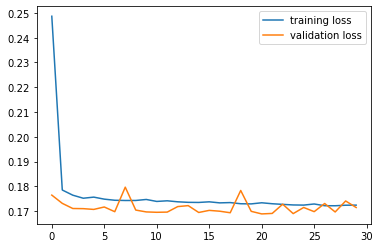

In [167]:
plt.plot(history.history['loss'],label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

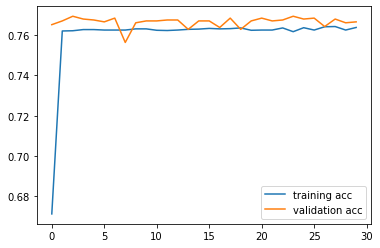

In [168]:
plt.plot(history.history['Acc'],label = "training acc")
plt.plot(history.history['val_Acc'], label = "validation acc")
plt.legend()
plt.show()

### pytorch

In [169]:
# load libraries
import torch
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [170]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [171]:
# convert train data to list with labels
train_data = []
for i in range(len(train)):
    train_data.append((int(train['helpfulness_cat'][i]), train['imdb_user_review'][i]))

In [172]:
# check null values in train_data
null_count = 0
for i in range(len(train_data)):
    if train_data[i][0] == 'nan':
        null_count += 1
print("Null values in train_data:", null_count)


Null values in train_data: 0


In [173]:
# convert train_data to iterator
train_data_iter = iter(train_data)

In [174]:
# tokenization
tokenizer = get_tokenizer('basic_english')
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_data_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [175]:
# tokenize Yelp reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x)

In [176]:
train_data_iter = iter(train_data)

In [177]:
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
dataloader = DataLoader(train_data_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [178]:
train_data_iter = iter(train_data)

In [179]:
# %%
# model creation

# load libraries
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [180]:
# %%
# model set up
train_data_iter = iter(train_data)
# examples
# classes
num_class = len(set([label for (label, text) in train_data_iter]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [137]:
train_data_iter = iter(train_data)

In [182]:
# load library 
import time
# custom function for training 
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

In [183]:
# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [184]:
train_data_iter = iter(train_data)

In [185]:
# load libraries 
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# hyperparameters for the search
# --+ epoch
EPOCHS = 10 
# --+ learning rate
LR = 5  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling
train_dataset = to_map_style_dataset(train_data_iter)
#test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
#test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             #shuffle=True, collate_fn=collate_batch)

In [186]:
# check the train_dataloader
for batch in train_dataloader:
    print(batch)
    break

(tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]), tensor([  95,    6,   33,  ..., 1047,  152,    1]), tensor([    0,   176,   341,   355,   505,   550,   652,   819,  2021,  2685,
         2801,  3010,  3730,  3859,  4011,  4208,  4322,  4449,  4606,  4634,
         4990,  5317,  5911,  5936,  6703,  6815,  6887,  7031,  7459,  7711,
         7918,  8073,  8169,  8206,  8309,  8433,  8607,  8751,  8955,  9008,
         9105,  9241,  9382,  9549,  9561,  9577, 10450, 10863, 11005, 11034,
        11205, 11399, 11972, 12010, 12176, 12805, 12920, 12946, 13013, 13065,
        13109, 13231, 13382, 13627]))


In [187]:
# logging
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


-----------------------------------------------------------
| end of epoch   1 | time:  2.34s | valid accuracy    0.768 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  2.29s | valid accuracy    0.768 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  2.33s | valid accuracy    0.755 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  2.31s | valid accuracy    0.770 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  2.37s | valid accuracy    0.764 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  2.39s |

In [199]:
# test on random unseen review

# labels
review_label = {1: "helpful",
                0: "unhelpful"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "yes"

model = model.to("cpu")

print("This is a %s movie review" %review_label[predict(ex_text_str, text_pipeline)])

This is a helpful movie review
